In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import scipy.constants as cte
from scipy import special
import astropy.units as u
from plasmapy.diagnostics import thomson

# Kudeki's benchmark

In [2]:
# Parameters definition
f_radar = 41*10**6 # (Hz)
k = (4*pi*f_radar)/cte.c
f = np.linspace(-4,4,num=10000)*10**3
w = 2*pi*f

m_e = cte.m_e # (kg)
m_i = cte.m_p # (kg)
T_i = 1000 # (K)
T_e = T_i # (K)
n_i = 10**11 # (1/m^3)
n_e = n_i # (1/m^3)
vth_e = np.sqrt(cte.k*T_e/m_e)
vth_i = np.sqrt(cte.k*T_i/m_i)
h_e = np.sqrt(cte.epsilon_0*cte.k*T_e/(n_e*cte.e**2))
h_i = np.sqrt(cte.epsilon_0*cte.k*T_i/(n_i*cte.e**2))
w_pe = np.sqrt(n_e*cte.e**2/(cte.epsilon_0*m_e))
w_pi = np.sqrt(n_i*cte.e**2/(cte.epsilon_0*m_i))
print("Regime constant α:", cte.c/(4*pi*f_radar*h_e))

Regime constant α: 84.3182083216321


In [3]:
w_pe/(2*pi)

2839302.485541182

Gordeyev's integral equation:
$$ J(\omega) = \frac{1}{\sqrt{2}kC}\left[ -\sqrt{\pi}e^{-\theta^2} - j2e^{-\theta^2}\int_{0}^{\theta}{e^{t^2}\, dt} \right] $$
$$\theta = \frac{\omega}{\sqrt{2}kC}$$

In [4]:
def Js(k,w,Cs):
    ''' 
    k: wave vector
    w: angular frequency
    Cs: thermal speed of the specie s
    '''
    theta = w/(np.sqrt(2)*k*Cs)
    J1 = np.sqrt(pi)*np.exp(-theta**2)
    J2 = -2j*special.dawsn(theta)
    Js = (1/(np.sqrt(2)*k*Cs))*(J1 + J2)
    return Js

def nts(k, w, Cs, N0=n_e, Vs=0):
    ws = w - k*Vs
    nts = 2*N0*np.real(Js(k,ws,Cs))
    return nts

def sigma_s(k,w,Cs,hs,Vs=0):
    ws = w - k*Vs
    sigma_s = (1j*w*cte.epsilon_0)*(1-1j*ws*Js(k,ws,Cs))/((k*hs)**2)
    return sigma_s

def spectrum(k, w):
    sigma_e = sigma_s(k,w,vth_e,h_e)
    sigma_i = sigma_s(k,w,vth_i,h_i)
    nte = nts(k,w,vth_e,n_e)
    nti = nts(k,w,vth_i,n_i)
    den = abs(1j*w*cte.epsilon_0 + sigma_e + sigma_i)**2
    Se = (abs(1j*w*cte.epsilon_0 + sigma_i)**2)*nte/den
    Si = (abs(sigma_e)**2)*nti/den
    S = Se + Si
    return S

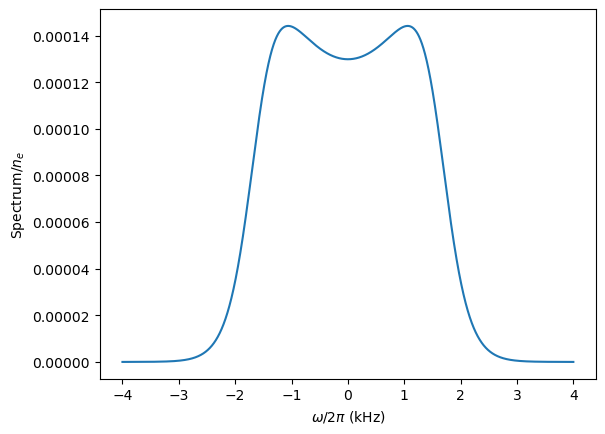

In [5]:
S = spectrum(k, w)
fig, ax = plt.subplots()
ax.plot(w/(2*pi*1000),S/n_e)
# ax.axvline(x=w_pi/(2*pi*1000), color='r', linestyle='--', label='Vertical Line')
plt.xlabel('$\omega/2\pi$ (kHz)'); plt.ylabel('Spectrum$/n_e$')
plt.show()

# PlasmaPy

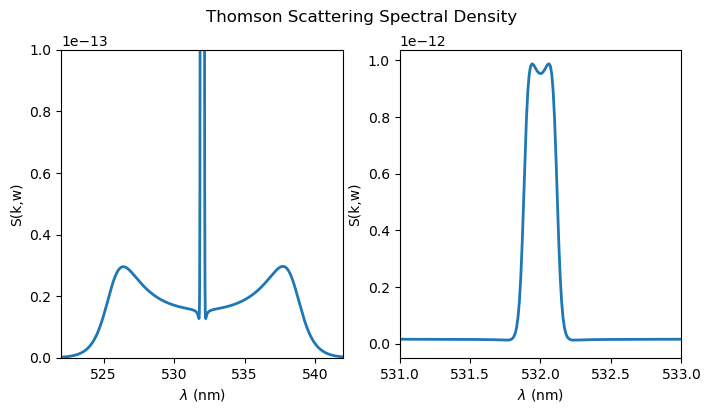

In [39]:
# The probe wavelength can in theory be anything, but in practice integer frequency multiples of the Nd:YAG wavelength
# 1064 nm are used (532 corresponds to a frequency-doubled probe beam from such a laser).
probe_wavelength = 532 * u.nm

# Array of wavelengths over which to calculate the spectral distribution
wavelengths = (
    np.arange(probe_wavelength.value - 60, probe_wavelength.value + 60, 0.01) * u.nm
)

# The scattering geometry is defined by unit vectors for the orientation of the probe laser beam (probe_n) and
# the path from the scattering volume (where the measurement is made) to the detector (scatter_n).
# These can be setup for any experimental geometry.
probe_vec = np.array([1, 0, 0])
scattering_angle = np.deg2rad(63)
scatter_vec = np.array([np.cos(scattering_angle), np.sin(scattering_angle), 0])

alpha, Skw = thomson.spectral_density(
    probe_wavelength=probe_wavelength,
    wavelengths=wavelengths,
    n=2e23 * u.m**-3,
    Te=12 * u.eV,
    Ti=10 * u.eV,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(8, 4))
fig.suptitle("Thomson Scattering Spectral Density")
ax1.plot(wavelengths, Skw, lw=2)
ax1.set_xlim(probe_wavelength.value - 10, probe_wavelength.value + 10)
ax1.set_ylim(0, 1e-13)
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("S(k,w)")
ax2.plot(wavelengths, Skw, lw=2)
ax2.set_xlim(probe_wavelength.value - 1, probe_wavelength.value + 1)
# ax2.set_ylim(0, 1e-13)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("S(k,w)")
plt.show()

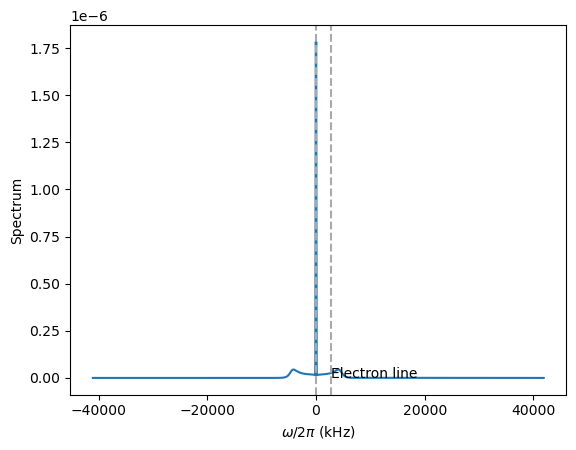

In [8]:
ks = 1.2/h_e
fs = ks*cte.c/(4*pi)
probe_wavelength = ((cte.c/fs)*u.m).to(u.nm)
dl = probe_wavelength.value*0.01
wavelengths = (np.linspace(probe_wavelength.value - dl, probe_wavelength.value + dl, num=10000) * u.nm)
frecuencies = cte.c/(wavelengths.to(u.m).value)
df = frecuencies - fs

def SpectralDensityPlasmaPy(probe_wavelength,wavelengths,n_Elc,T_Elc,T_Ion):
	probe_vec = np.array([1, 0, 0])
	scattering_angle = np.deg2rad(63)
	scatter_vec = np.array([np.cos(scattering_angle), np.sin(scattering_angle), 0])
 
	n_Elc_dim = n_Elc*(u.m**-3)
	T_Elc_dim = T_Elc*(u.K)
	T_Ion_dim = T_Ion*(u.K)
	
	alpha, Skw = thomson.spectral_density(
    	wavelengths,
    	probe_wavelength,
    	n_Elc_dim,
    	Te=T_Elc_dim,
    	Ti=T_Ion_dim,
		ion_species= "H+",
    	probe_vec=probe_vec,
    	scatter_vec=scatter_vec,
	)
	return alpha, Skw

[alpha, Skw] = SpectralDensityPlasmaPy(probe_wavelength,wavelengths,n_e,T_e,T_i)

fig, ax = plt.subplots()
ax.plot(df/1e3,Skw)
# plt.xlim(np.array([-1,1])*df[0]*0.01/1000)
plt.xlabel('$\omega/2\pi$ (kHz)'); plt.ylabel('Spectrum')
ax.axvline(x=w_pi/(2*pi*1000), color='darkgray', linestyle='--', label='A')
ax.axvline(x=w_pe/(2*pi*1000), color='darkgray', linestyle='--', label='Vertical Line')
ax.annotate('Electron line', xy=(w_pe/(2*pi*1000), 0))
plt.show()

# Diaz (2008)

In [43]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import scipy.constants as cte

In [44]:
def spectrum(ks,w):
    Ge = Fgordeyev(xe)
    Gi = Fgordeyev(xi)*Z*(Te/Ti) # Este ultimo termino afecta la profundidad del valle
    vx = w/ks
    fe0 = maxwellian1D(vx,vthe)
    fi0 = maxwellian1D(vx,vthi)
    eps = 1+Ge+Gi
    S1 = (2*pi/ks)*(np.abs(1-Ge/eps)**2)*fe0
    S2 = (2*pi*Z/ks)*(np.abs(Ge/eps)**2)*fi0

    out = S1+S2
    return out

def maxwellian1D(vx, vth):
    fs0 = np.exp(-vx**2/vth**2)/((pi*vth**2)**(3/2)) # 1/2 ----- 3/2
    return fs0

def Fgordeyev(xs):
    F1 = 1
    F2 = 2*xs*np.exp(-xs**2)*integ(xs)
    F3 = 1j*np.sqrt(pi)*xs*np.exp(-xs**2)
    Gs = (alpha**2)*(F1-F2-F3)
    return Gs

def integ(xs):
    p = np.linspace(0,xs,1000)
    yp = np.exp(p**2)
    out = np.trapz(yp,p)
    return out

def xs(k,w,vths):
    out = w/(k*vths)
    return out

# def scale(X, x_min, x_max):
#     nom = (X-X.min(axis=0))*(x_max-x_min)
#     denom = X.max(axis=0) - X.min(axis=0)
#     denom[denom==0] = 1
#     return x_min + nom/denom 


In [45]:
# Propiedades características de las especies
mi = 1.6726*10**(-27) # (kg)
me = 3.3452*10**(-30) # (kg) 
Ti = 1000             # (K)
Te = 2*Ti             # (K)
ni = 10**11           # (1/m^3)
ne = ni               # (1/m^3)

# Fórmulas
vthe = np.sqrt(2*cte.k*Te/me) # Electron thermal speed
vthi = np.sqrt(2*cte.k*Ti/mi) # Ion thermal speed
lambdaD = np.sqrt(cte.epsilon_0*cte.k*Te/(ne*cte.e**2))
wpe = np.sqrt(ne*cte.e**2/(cte.epsilon_0*me))
# NOTA: si a = sqrt(2*...) ---> a ~= lambdaD*wpe
#          a = sqrt(...)   ---> a  = lambdaD*wpe
Z = 1 # No se indica

# Parámetros de simulación
Nx = 256
Lx = 2.56 # 250*lambdaD
dx = Lx/(Nx)              # Configuration space resolution
dk = 1/(Nx*dx)              # Wave number resolution
dt = 0.1*10**-6
Ns = 4*10**-6/dt
Tsam = Ns*dt
NT = 0.92*10**-3/(Ns*dt)
TT = NT*Ns*dt
Np= 500000

# dx = 2*Lx/(Nx-1)              # Configuration space resolution
# dk = 1/(Nx*dx)              # Wave number resolution

In [46]:
# Configuración del dominio de S(k,w)
# Vector de onda ks
ks = np.arange(0.1,180,dk)
Nk = ks.size # numero de puntos de ks
# M = 500 # wave vector resolution
# ks = np.linspace(1,160,M) # (1/m)
# Frecuencia f
Nf = 100 # numero de puntos de f
f = np.linspace(-100,100,Nf)*1000 # (Hz)
w = 2*pi*f

# Calculo del espectro S(k,w)
S1 = np.zeros((Nf,Nk))
for j in range(Nk):
    alpha = 1/(ks[j]*lambdaD)
    for i in range(Nf):
        xe = xs(ks[j],w[i],vthe)
        xi = xs(ks[j],w[i],vthi)
        S1[i,j] = spectrum(ks[j],w[i])

/tmp/ipykernel_52011/2192621132.py:27: RuntimeWarning: overflow encountered in exp
  yp = np.exp(p**2)
/tmp/ipykernel_52011/2192621132.py:20: RuntimeWarning: invalid value encountered in double_scalars
  F2 = 2*xs*np.exp(-xs**2)*integ(xs)
/home/germain.rosadio/.conda/envs/pgkylenv/lib/python3.8/site-packages/numpy/lib/function_base.py:4234: RuntimeWarning: overflow encountered in add
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
/tmp/ipykernel_52011/2192621132.py:22: RuntimeWarning: invalid value encountered in multiply
  Gs = (alpha**2)*(F1-F2-F3)
/tmp/ipykernel_52011/2192621132.py:3: RuntimeWarning: invalid value encountered in cdouble_scalars
  Gi = Fgordeyev(xi)*Z*(Te/Ti) # Este ultimo termino afecta la profundidad del valle


In [47]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def corte(f_radar):
    k_radar = (4*pi*f_radar)/cte.c
    [_,idx] = find_nearest(ks,k_radar)
    return idx

In [48]:
f_radar = ks*cte.c/(4*pi)
idx1 = corte(527*10**6)
idx2 = corte(879*10**6)
idx3 = corte(1289*10**6)
S1_w = S1[:,idx1]/np.nanmax(S1[:,idx1])
S2_w = S1[:,idx2]/np.nanmax(S1[:,idx1])
S3_w = S1[:,idx3]/np.nanmax(S1[:,idx1])
print(ks[idx1])

21.975


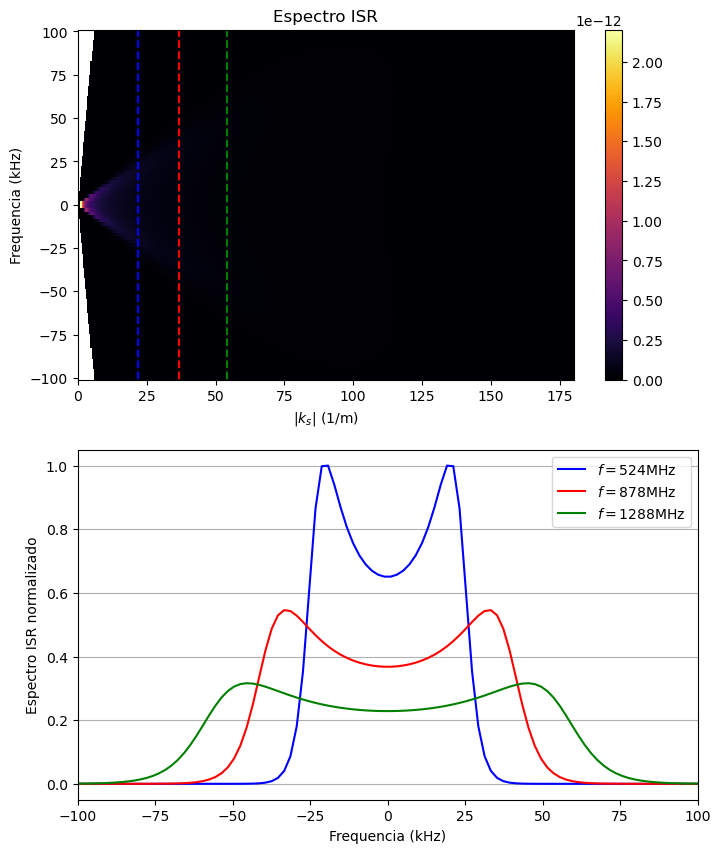

In [49]:
plt.figure(figsize=(8,10),dpi=100)
plt.subplots_adjust(wspace=0.35)

plt.subplot(2,1,1)
plt.pcolormesh(ks,f/1000,(S1),cmap='inferno')
plt.colorbar()
plt.xlabel('$|k_s|$ (1/m)')
plt.ylabel('Frequencia (kHz)')
plt.title('Espectro ISR')
plt.axvline(x=ks[idx1], ymin=f[0], ymax=f[-1],color='b',ls='--')
plt.axvline(x=ks[idx2], ymin=f[0], ymax=f[-1],color='r',ls='--')
plt.axvline(x=ks[idx3], ymin=f[0], ymax=f[-1],color='g',ls='--')

plt.subplot(2,1,2)
plt.plot(f/1000,S1_w,label='$f=%d$MHz'%(f_radar[idx1]/10**6),color='b')
plt.plot(f/1000,S2_w,label='$f=%d$MHz'%(f_radar[idx2]/10**6),color='r')
plt.plot(f/1000,S3_w,label='$f=%d$MHz'%(f_radar[idx3]/10**6),color='g')
plt.xlabel('Frequencia (kHz)')
plt.ylabel('Espectro ISR normalizado')
plt.xlim([f[0]/1000, f[-1]/1000])
plt.legend()
plt.grid(axis='y')
plt.show()

# Sheffield

In [52]:
# Propiedades características de las especies
mi = 1.6726*10**(-27) # (kg)
me = 3.3452*10**(-30) # (kg) 
Ti = 1000             # (K)
Te = 2*Ti             # (K)
ni = 10**11           # (1/m^3)
ne = ni               # (1/m^3)

# Fórmulas
a = np.sqrt(2*cte.k*Te/me) # Electron thermal speed
b = np.sqrt(2*cte.k*Ti/mi) # Ion thermal speed
lambdaD = np.sqrt(cte.epsilon_0*cte.k*Te/(ne*cte.e**2))
wpe = np.sqrt(ne*cte.e**2/(cte.epsilon_0*me))
wpi = np.sqrt(ni*cte.e**2/(cte.epsilon_0*mi))
de = cte.c/wpe
# NOTA: si a = sqrt(2*...) ---> a ~= lambdaD*wpe
#          a = sqrt(...)   ---> a  = lambdaD*wpe
Z = 1 # No se indica

# Parámetros de simulación
Nx = 256
Lx = 2.56 # 250*lambdaD
dx = Lx/(Nx)              # Configuration space resolution
dk = 1/(Nx*dx)              # Wave number resolution
dt = 0.1*10**-6
Ns = 4*10**-6/dt
Tsam = Ns*dt
NT = 0.92*10**-3/(Ns*dt)
TT = NT*Ns*dt
Np= 500000

In [54]:
def sum1(x,N):
    vec = np.zeros((N,1))
    for n in range(1,N):
        vec[n] = (-2)**n*x**(2*n)/(4**n-1)
    out = np.cumsum(vec)
    return out[-1]

def sum2(x,N):
    vec = np.zeros((N,1))
    for n in range(1,N):
        vec[n] = (4**n-1)/(2**n*x**(2*n))
    out = np.cumsum(vec)
    return out[-1]

def integ(x,N):
    p = np.linspace(0,x,N)
    Fp = np.exp(p**2)
    out = np.trapz(Fp,p)
    return out

def Rw(x):
    out = 1 - 2*x*np.exp(-x**2)*integ(x,500)
    return out

def Iw(x):
    out = np.sqrt(pi)*x*np.exp(-x**2)
    return out

In [50]:
def Ae(xe,xi):
    Ae1 = (1+alpha**2*(Z*Te/Ti)*Rw(xi))**2
    Ae2 = (alpha**2*(Z*Te/Ti)*Iw(xi))**2
    out = np.exp(-xe**2)*(Ae1 + Ae2)
    return out

def Ai(xe,xi):
    Ai1 = (alpha**2*Rw(xe))**2
    Ai2 = (alpha**2*Iw(xe))**2
    out = Z*np.sqrt(mi*Te/(me*Ti))*np.exp(-xi**2)*(Ai1 + Ai2)
    return out

def modE(xe,xi):
    E1 = (1 + alpha**2*(Rw(xe) + (Z*Te/Ti)*Rw(xi)))**2
    E2 = (alpha**2*Iw(xe) + alpha**2*(Z*Te/Ti)*Iw(xi))**2
    out = E1 + E2
    return out

def xs(k,w,vth):
    out = w/(k*vth)
    return out

def S_kw(k,w):
    out = (2*np.sqrt(pi/(k*a)))*(Ae(xe,xi) + Ai(xe,xi))/modE(xe,xi)
    return out

In [55]:
# Configuración del dominio de S(k,w)
# Vector de onda ks
# ks = np.arange(0,180,dk)
# M = ks.size # numero de puntos de ks
M = 500 # wave vector resolution
ks = np.linspace(1,1/lambdaD,M) # (1/m)
# Frecuencia f
N = 1000 # numero de puntos de f
fLim = 2*wpe/(2*pi) # limite de frecuencia [-fLim, fLim]
fOrden = 10**6 # (Hz) orden de magnitud
f = np.linspace(-fLim,fLim,N)#*fOrden # (Hz)
w = 2*pi*f

# Calculo del espectro S(k,w)
S = np.zeros((N,M))
for j in range(M):
    alpha = 1/(ks[j]*lambdaD)
    for i in range(N):
        xe = xs(ks[j],w[i],a)
        xi = xs(ks[j],w[i],b)
        S[i,j] = S_kw(ks[j],w[i])

/tmp/ipykernel_52011/956124393.py:17: RuntimeWarning: overflow encountered in exp
  Fp = np.exp(p**2)
/tmp/ipykernel_52011/956124393.py:22: RuntimeWarning: invalid value encountered in double_scalars
  out = 1 - 2*x*np.exp(-x**2)*integ(x,500)
/home/germain.rosadio/.conda/envs/pgkylenv/lib/python3.8/site-packages/numpy/lib/function_base.py:4234: RuntimeWarning: overflow encountered in multiply
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
/tmp/ipykernel_52011/1137557466.py:10: RuntimeWarning: invalid value encountered in double_scalars
  out = Z*np.sqrt(mi*Te/(me*Ti))*np.exp(-xi**2)*(Ai1 + Ai2)
/tmp/ipykernel_52011/1137557466.py:24: RuntimeWarning: invalid value encountered in double_scalars
  out = (2*np.sqrt(pi/(k*a)))*(Ae(xe,xi) + Ai(xe,xi))/modE(xe,xi)


In [59]:
f_radar = ks*cte.c/(4*pi)
idx1 = corte(527*10**6)
idx2 = corte(879*10**6)
idx3 = corte(1289*10**6*2)
S1_w = S[:,idx1]/np.nanmax(S[:,idx1])
S2_w = S[:,idx2]/np.nanmax(S[:,idx1])
S3_w = S[:,idx3]/np.nanmax(S[:,idx1])
print(ks[idx1]*lambdaD)

0.21614216580718326


<function matplotlib.pyplot.show(close=None, block=None)>

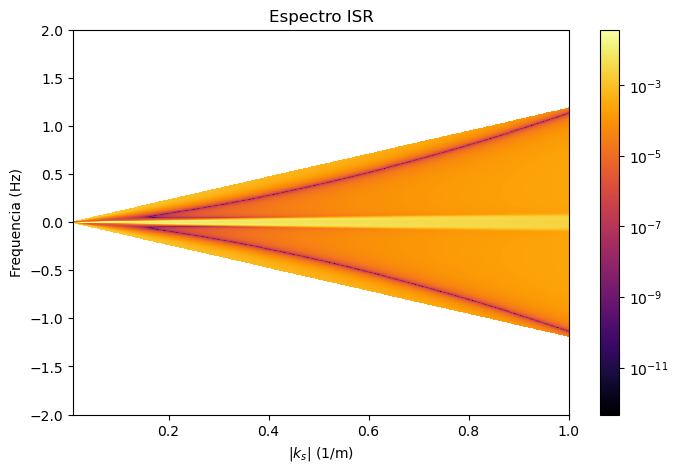

In [60]:
from matplotlib import colors
plt.figure(figsize=(8,5),dpi=100) # f/fOrden
plt.pcolormesh(ks*lambdaD,w/wpe,(np.abs(S)),cmap='inferno',norm=colors.LogNorm()) # vmin=np.min(np.abs(S)), vmax=np.max(np.abs(S))
plt.colorbar()
plt.xlabel('$|k_s|$ (1/m)')
plt.ylabel('Frequencia (Hz)')
plt.title('Espectro ISR')
# plt.ylim([-wpi/Zw, wpi/Zw])
# plt.ylim([-0.2, 0.2])
plt.show

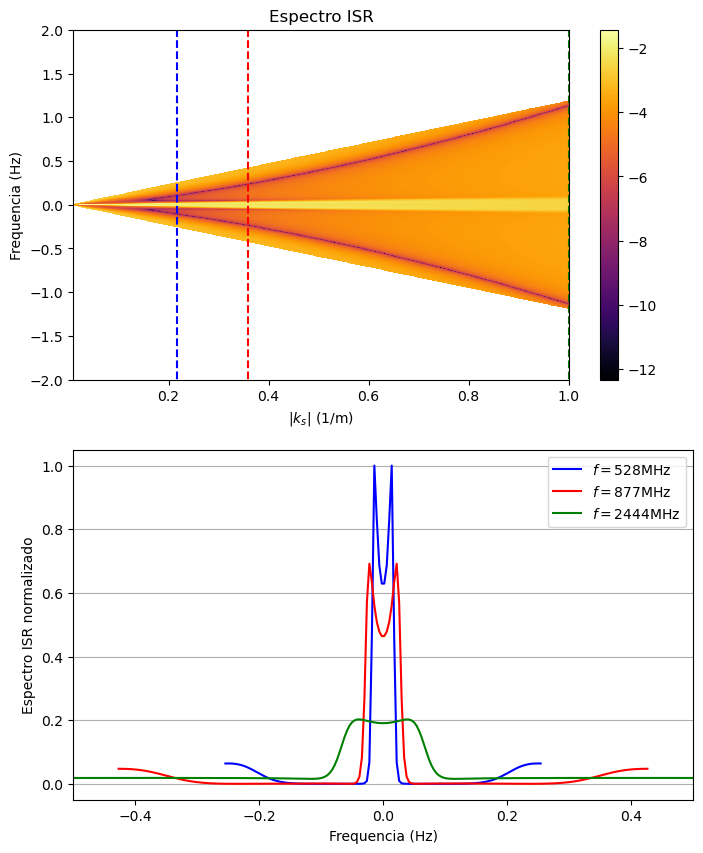

In [61]:
plt.figure(figsize=(8,10),dpi=100)
plt.subplots_adjust(wspace=0.35)

plt.subplot(2,1,1)
plt.pcolormesh(ks*lambdaD,w/wpe,np.log10(S),cmap='inferno')
plt.colorbar()
plt.xlabel('$|k_s|$ (1/m)')
plt.ylabel('Frequencia (Hz)')
plt.title('Espectro ISR')
plt.axvline(x=ks[idx1]*lambdaD, ymin=f[0], ymax=f[-1],color='b',ls='--')
plt.axvline(x=ks[idx2]*lambdaD, ymin=f[0], ymax=f[-1],color='r',ls='--')
plt.axvline(x=ks[idx3]*lambdaD, ymin=f[0], ymax=f[-1],color='g',ls='--')

plt.subplot(2,1,2)
plt.plot(w/wpe,S1_w,label='$f=%d$MHz'%(f_radar[idx1]/10**6),color='b')
plt.plot(w/wpe,S2_w,label='$f=%d$MHz'%(f_radar[idx2]/10**6),color='r')
plt.plot(w/wpe,S3_w,label='$f=%d$MHz'%(f_radar[idx3]/10**6),color='g')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Espectro ISR normalizado')
# plt.xlim([f[0]/fOrden, f[-1]/fOrden])
plt.xlim([-0.5, 0.5])
plt.legend()
plt.grid(axis='y')
plt.show()